In [1]:
import pandas as pd
from RoutePlanner.CellGrid import CellGrid
from RoutePlanner.IO import LoadIcePoints, LoadCurrentPoints
from RoutePlanner.Optimisation import TravelTime

def GreatCircle(Start_p,End_p):
    import pyproj
    import numpy as np
    startlong, startlat = Start_p
    endlong, endlat     = End_p
    startlong = startlong-360
    endlong   = endlong-360

    # calculate distance between points
    g = pyproj.Geod(ellps='WGS84')
    (az12, az21, dist) = g.inv(startlong, startlat, endlong, endlat)

    # calculate line string along path with segments <= 1 km
    lonlats = g.npts(startlong, startlat, endlong, endlat,
                    1 + int(dist / 1000))

    lonlats = np.array(lonlats)
    lonlats[:,0] = lonlats[:,0]+360

    return lonlats

In [2]:
OptInfo = {}
OptInfo['Bounds Longitude']     = [230,360]
OptInfo['Bounds Latitude']      = [-80,-40]
OptInfo['Grid Spacing (dx,dy)'] = [5,2.5]
OptInfo['Start Time']           = '2017-05-01'
OptInfo['End Time']             = '2017-06-01'
OptInfo['WayPoints']            = pd.read_csv('../../resources/WayPoint_LongPaths.csv') 
OptInfo['MaxIceExtent']         = 0.8
OptInfo['Zero Currents']        = True
OptInfo['VariableSpeed']        = False
OptInfo['Time Unit']            = 'days'
OptInfo['VehicleInfo']          = {}
OptInfo['VehicleInfo']['Speed'] = 26.3
OptInfo['VehicleInfo']['Unit']  = 'km/hr'
OptInfo['Start Waypoints']      = None

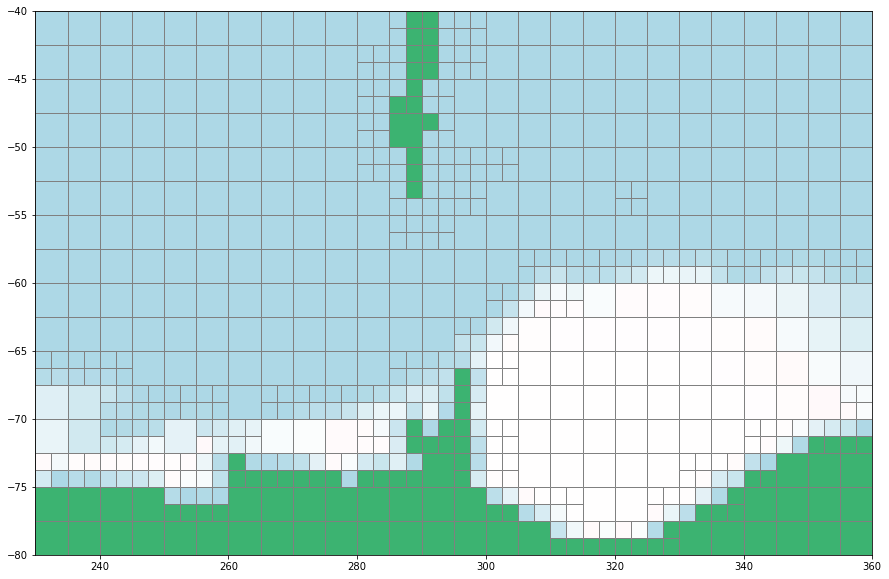

In [3]:
icePoints     = LoadIcePoints('../../Data/bsose_i122_2013to2017_1day_SeaIceArea.nc',OptInfo['Start Time'],OptInfo['End Time'])
currentPoints = LoadCurrentPoints('../../Data/SOSE_surface_velocity_6yearMean_2005-2010.nc')

cellGrid = CellGrid(OptInfo)
cellGrid.addIcePoints(icePoints)
cellGrid.addCurrentPoints(currentPoints)
cellGrid.recursiveSplit(1)
cellGrid.plot()

=== Processing Waypoint = LongPathStart ===
=== Processing Waypoint = LongPathEnd ===


<AxesSubplot:>

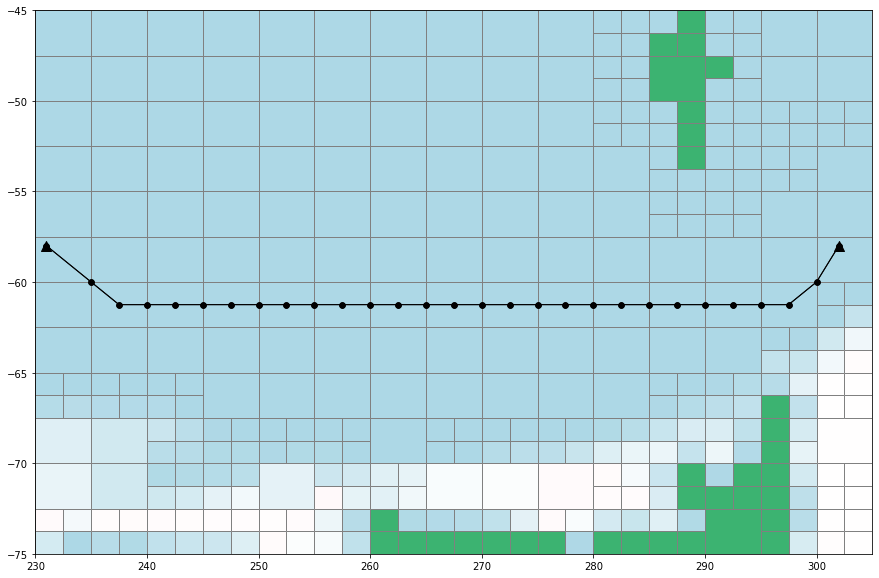

In [4]:
TT = TravelTime(cellGrid)
TT.Dijkstra(verbrose=True)
TT.PlotPaths(routepoints=True,xlim=[230,305],ylim=[-75,-45])

In [5]:
TT.PathSmoothing()

 PATH: LongPathStart -> LongPathEnd 
Issue - No Corner Cp=(260.0, -62.43500181608517);
Sp=(265.0,-62.63606033227359);Cp=(260.0,-62.43500181608517);Np=(255.0,-62.39898534880609)
Box1=(262.5,-63.75);Box2=(257.5,-61.25)
No-Case: df_X=-5.0,df_Y=2.5
Neighbour Index [139, 140, 141, 183, 184, 185, 141, 163, 185, 139, 161, 183]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
ax = TT.PlotPaths(routepoints=True,xlim=[230,305],ylim=[-75,-45])

GT = pd.read_csv('../../resources/GroundTruth_LongPath_End2Start_Smooth.csv')
GT['Long'] = GT['Long'] + 360
ax.plot(GT['Long'],GT['Lat'],'b')

PATH1 =  TT.Paths[0]['Path']['FullPath']
gc = GreatCircle((PATH1[0,0],PATH1[0,1]),(PATH1[-1,0],PATH1[-1,1]))

ax.plot(gc[:,0],gc[:,1],'r')


Sp=(265.0,-62.63606033227359);Cp=(260.0,-62.43500181608517);Np=(255.0,-62.39898534880609)
Box1=(262.5,-63.75);Box2=(257.5,-61.25)
ax.scatter(Sp[0],Sp[1],15,'r')
ax.scatter(Cp[0],Cp[1],15,'r')
ax.scatter(Np[0],Np[1],15,'r')

ax.scatter(Box1[0],Box1[1],50,'b',zorder=200)
ax.scatter(Box2[0],Box2[1],50,'b',zorder=200)



In [ ]:
pts = TT.Paths[0]['Path']['FullPath']
pts[:,0] = pts[:,0]-360

geoJSON = {}
geoJSON['type'] = "Feature"

geoJSON['geometry'] = {}
geoJSON['geometry']['type'] = "LineString"
geoJSON['geometry']['coordinates'] =TT.Paths[0]['Path']['FullPath'].tolist()

geoJSON['properties'] = {}
geoJSON['properties']['from'] = TT.Paths[0]['from']
geoJSON['properties']['to'] = TT.Paths[0]['to']
geoJSON['properties']['Travel Time (d)'] = TT.Paths[0]['TotalCost']

import json
with open('Paths.json', 'w') as fp:
    json.dump(geoJSON, fp)